In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import graphviz
from IPython.display import display, Markdown
import seaborn as sns

import os
project_dir = os.getcwd()
graphviz_bin_path = os.path.join(project_dir, "bin")
os.environ["PATH"] += os.pathsep + graphviz_bin_path

# Read data from a CSV file

In [2]:
file_path = 'data/winequality-combined.csv'
data = pd.read_csv(file_path, sep=',')

def classify_quality(quality):
    if quality <= 4:
        return 'Low'
    elif quality <= 6:
        return 'Medium'
    else:
        return 'High'

features = data.drop('quality', axis=1)
labels = data['quality'].apply(classify_quality)

print("Dataset Info:")
print(f"Samples: {len(data)}, Features: {len(features.columns)}")
print("\nQuality distribution:")
print(labels.value_counts())

Dataset Info:
Samples: 6497, Features: 12

Quality distribution:
quality
Medium    4974
High      1277
Low        246
Name: count, dtype: int64


# Split the data into train and test sets

In [3]:
def create_stratified_splits(features, labels, test_sizes):
    splits = {}
    for test_size in test_sizes:
        feature_train, feature_test, label_train, label_test = train_test_split(
            features, labels, 
            test_size=test_size, 
            random_state=42,
            stratify=labels
        )
        split_name = f"train_{100-int(test_size*100)}_test_{int(test_size*100)}"
        splits[split_name] = {
            'feature_train': feature_train,
            'label_train': label_train,
            'feature_test': feature_test,
            'label_test': label_test
        }
    return splits

test_sizes = [0.6, 0.4, 0.2, 0.1]
splits = create_stratified_splits(features, labels, test_sizes)

# Visualize the class distributions in all datasets

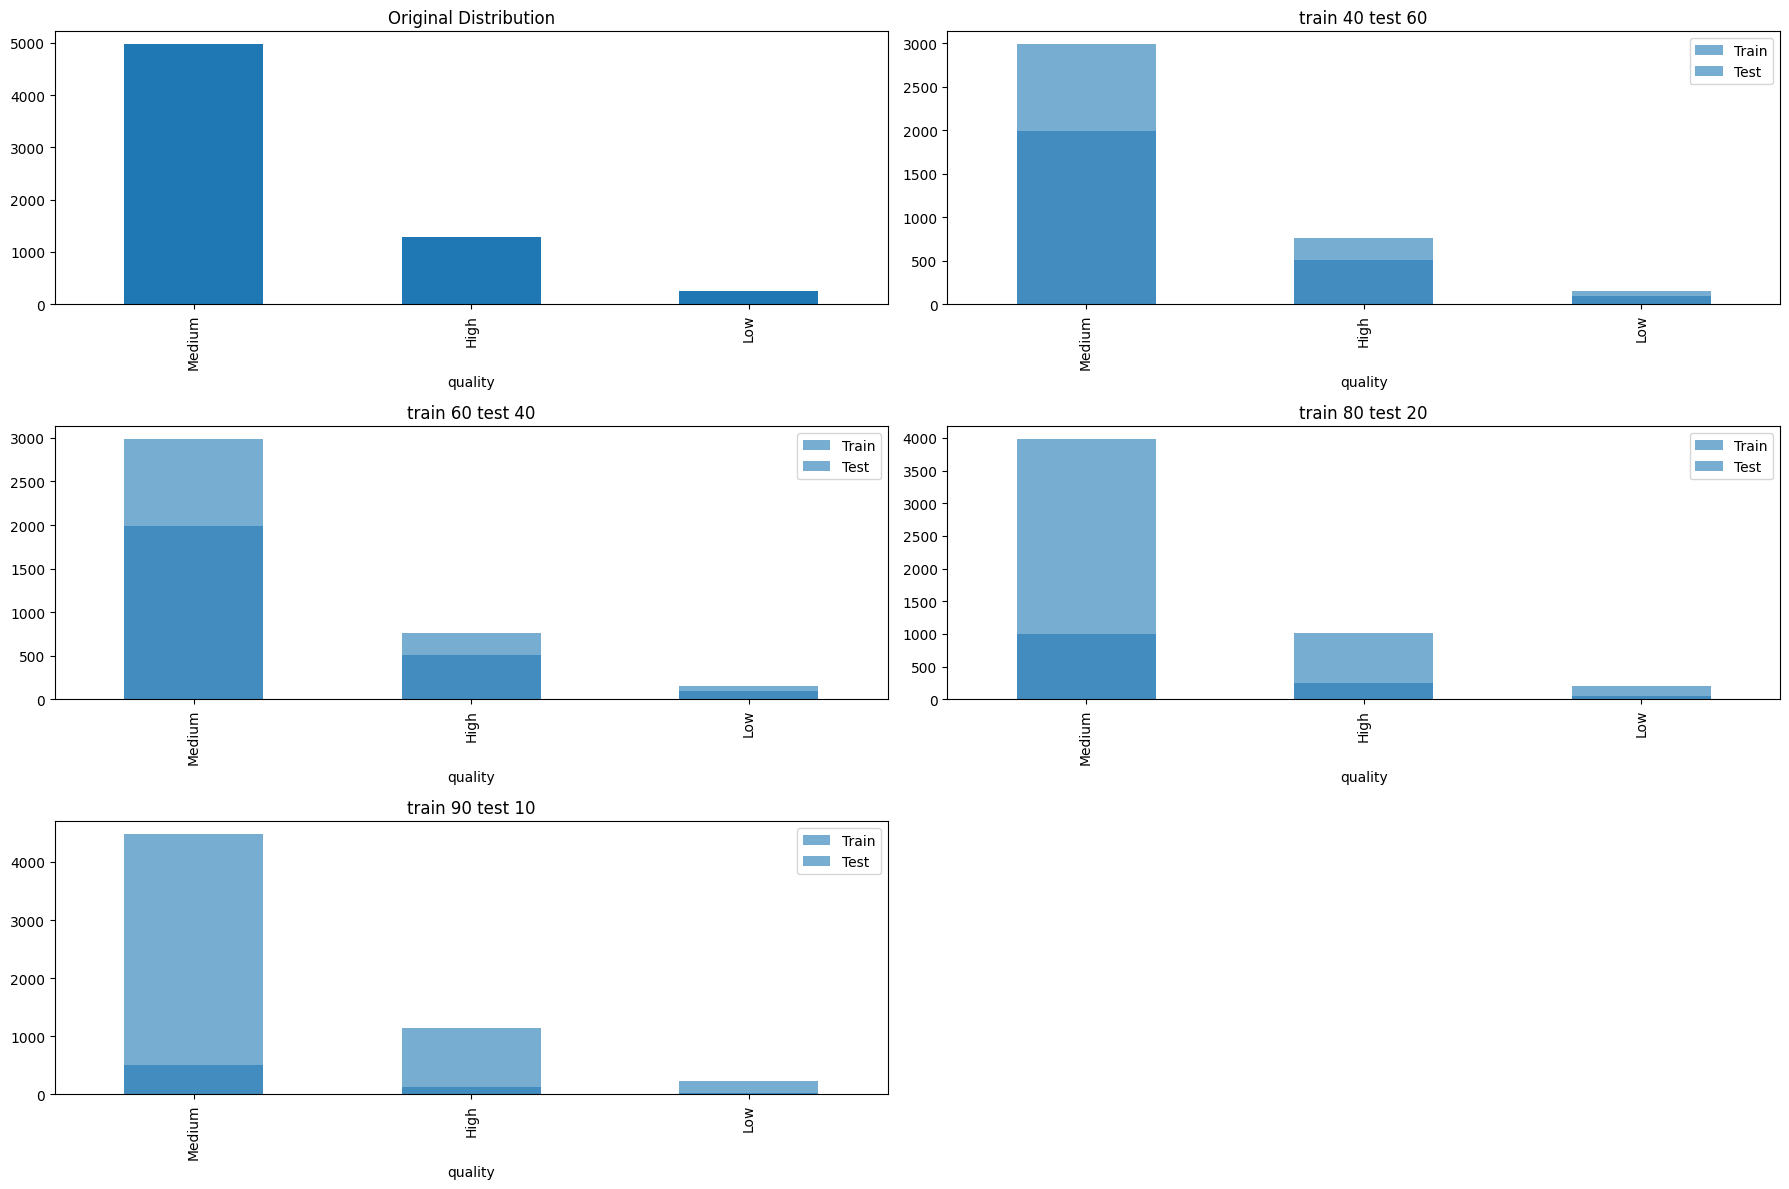

In [4]:
plt.figure(figsize=(18, 12))
plt.subplot(3, 2, 1)
labels.value_counts().plot(kind='bar')
plt.title('Original Distribution')

for i, (name, data) in enumerate(splits.items(), 2):
    plt.subplot(3, 2, i)
    data['label_train'].value_counts().plot(kind='bar', alpha=0.6, label='Train')
    data['label_test'].value_counts().plot(kind='bar', alpha=0.6, label='Test')
    plt.title(name.replace('_', ' '))
    plt.legend()

plt.tight_layout()
plt.show()

# Building the decision tree classifiers

In [5]:
def evaluate_tree(feature_train, label_train, feature_test, label_test, max_depth=None):
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    dt.fit(feature_train, label_train)
    predictions = dt.predict(feature_test)

    dot_data = export_graphviz(
        dt,
        out_file=None,
        feature_names=feature_train.columns,
        class_names=[str(x) for x in sorted(label_train.unique())],
        filled=True,
        rounded=True
    )
    display(graphviz.Source(dot_data))

    report = classification_report(label_test, predictions, target_names=sorted(label_train.unique()))
    acc = accuracy_score(label_test, predictions)
    cm = confusion_matrix(label_test, predictions, labels=sorted(label_train.unique()))
    
    display(Markdown(f"### 📋 Classification Report"))
    print(report)
    print(f"Accuracy: {acc:.2f}")

    display(Markdown(f"### 📊 Confusion Matrix"))

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='rocket_r',
                xticklabels=sorted(label_train.unique()), yticklabels=sorted(label_train.unique()))
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Decision Tree Classifier confusion matrix")
    plt.tight_layout()
    plt.show()

    return dt


#  Evaluating the decision tree classifiers

Evaluating all splits...

--------------------------------------------------
Evaluating train 40 test 60


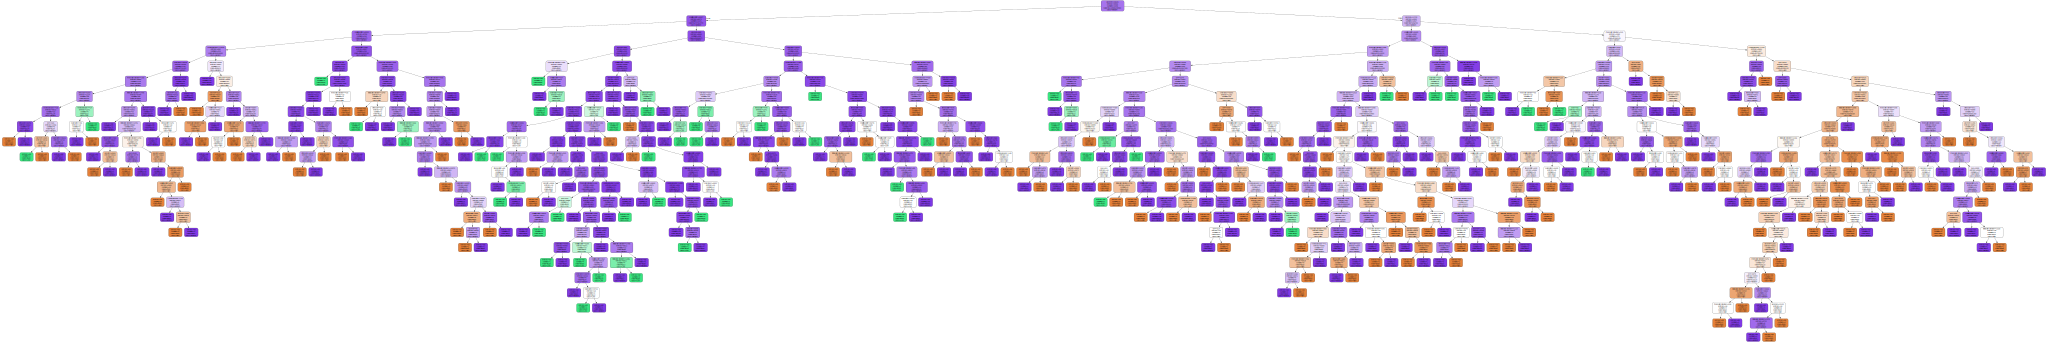

### 📋 Classification Report

              precision    recall  f1-score   support

        High       0.52      0.53      0.53       766
         Low       0.18      0.16      0.17       148
      Medium       0.84      0.84      0.84      2985

    accuracy                           0.76      3899
   macro avg       0.52      0.51      0.51      3899
weighted avg       0.75      0.76      0.76      3899

Accuracy: 0.76


### 📊 Confusion Matrix

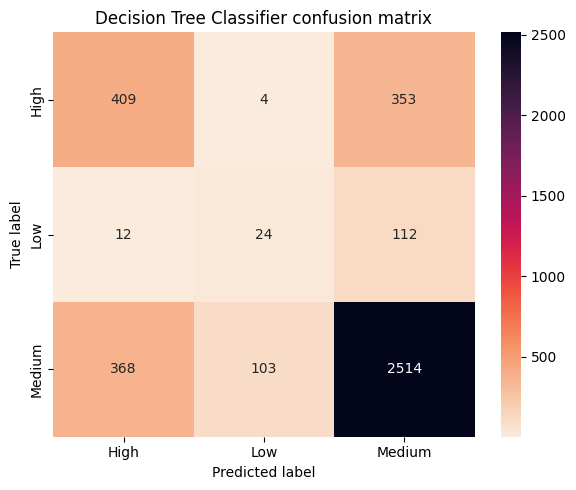


--------------------------------------------------
Evaluating train 60 test 40


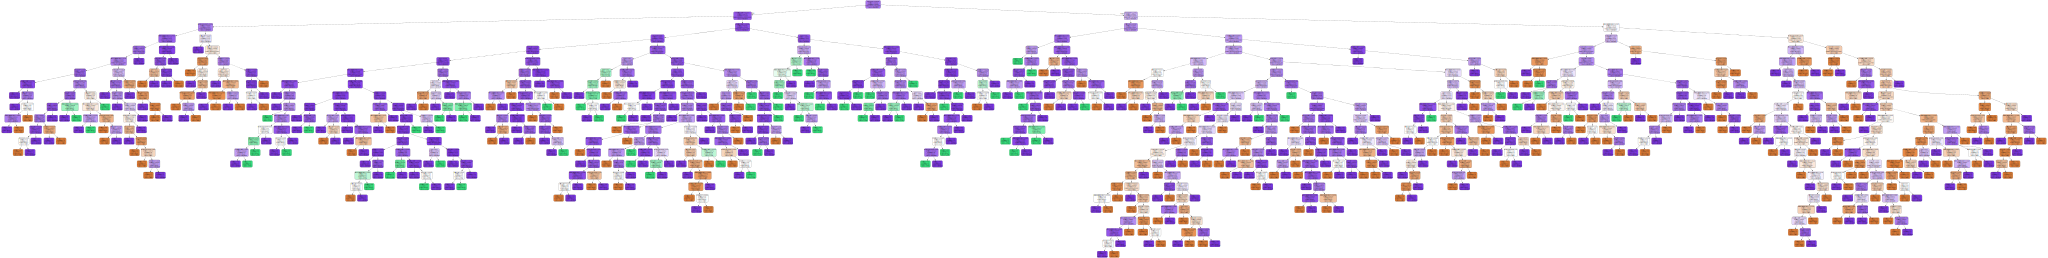

### 📋 Classification Report

              precision    recall  f1-score   support

        High       0.53      0.54      0.54       511
         Low       0.27      0.24      0.26        98
      Medium       0.85      0.85      0.85      1990

    accuracy                           0.77      2599
   macro avg       0.55      0.55      0.55      2599
weighted avg       0.77      0.77      0.77      2599

Accuracy: 0.77


### 📊 Confusion Matrix

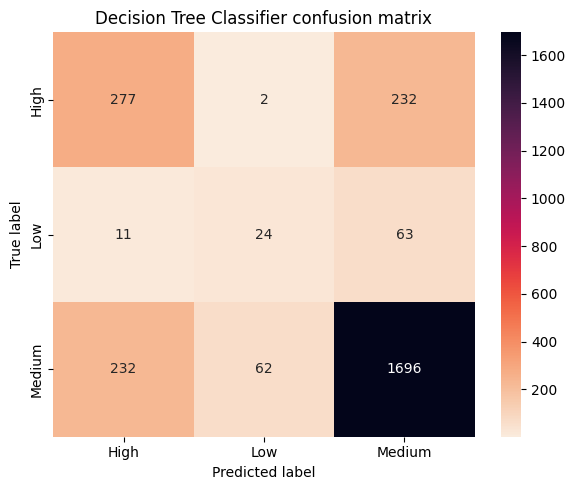


--------------------------------------------------
Evaluating train 80 test 20


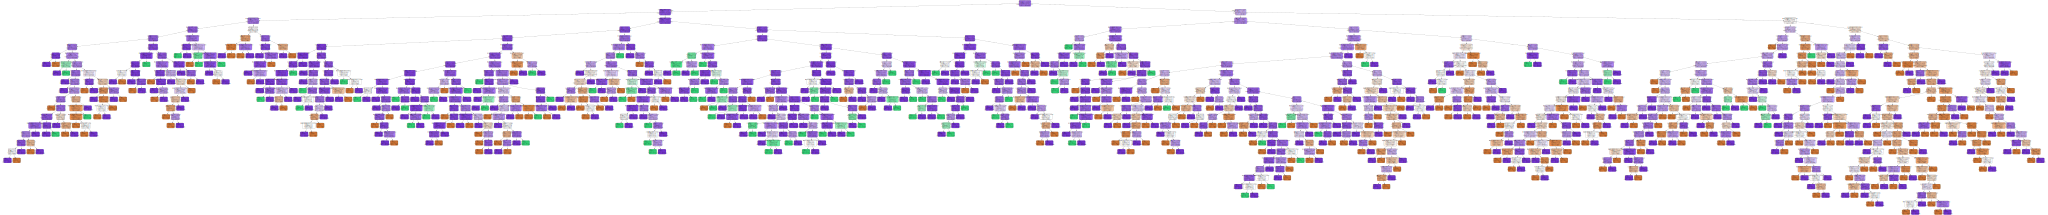

### 📋 Classification Report

              precision    recall  f1-score   support

        High       0.61      0.65      0.63       256
         Low       0.36      0.27      0.31        49
      Medium       0.88      0.88      0.88       995

    accuracy                           0.81      1300
   macro avg       0.62      0.60      0.60      1300
weighted avg       0.81      0.81      0.81      1300

Accuracy: 0.81


### 📊 Confusion Matrix

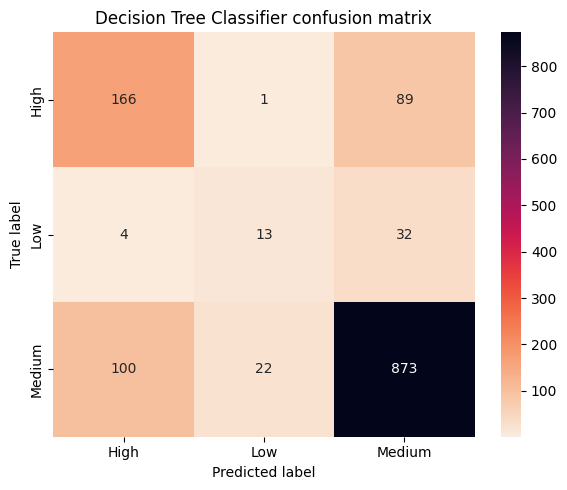


--------------------------------------------------
Evaluating train 90 test 10


### 📋 Classification Report

              precision    recall  f1-score   support

        High       0.59      0.65      0.62       128
         Low       0.32      0.38      0.35        24
      Medium       0.88      0.85      0.87       498

    accuracy                           0.79       650
   macro avg       0.60      0.62      0.61       650
weighted avg       0.80      0.79      0.80       650

Accuracy: 0.79


### 📊 Confusion Matrix

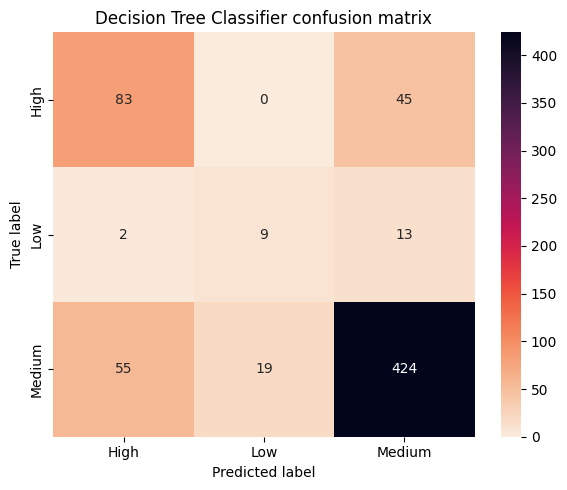

In [6]:
print("Evaluating all splits...")
for name, split in splits.items():
    print(f"\n{'-'*50}\nEvaluating {name.replace('_', ' ')}")
    evaluate_tree(
        split['feature_train'], 
        split['label_train'],
        split['feature_test'],
        split['label_test']
    )

# The depth and accuracy of a decision tree



Analyzing max_depth for 80/20 split...


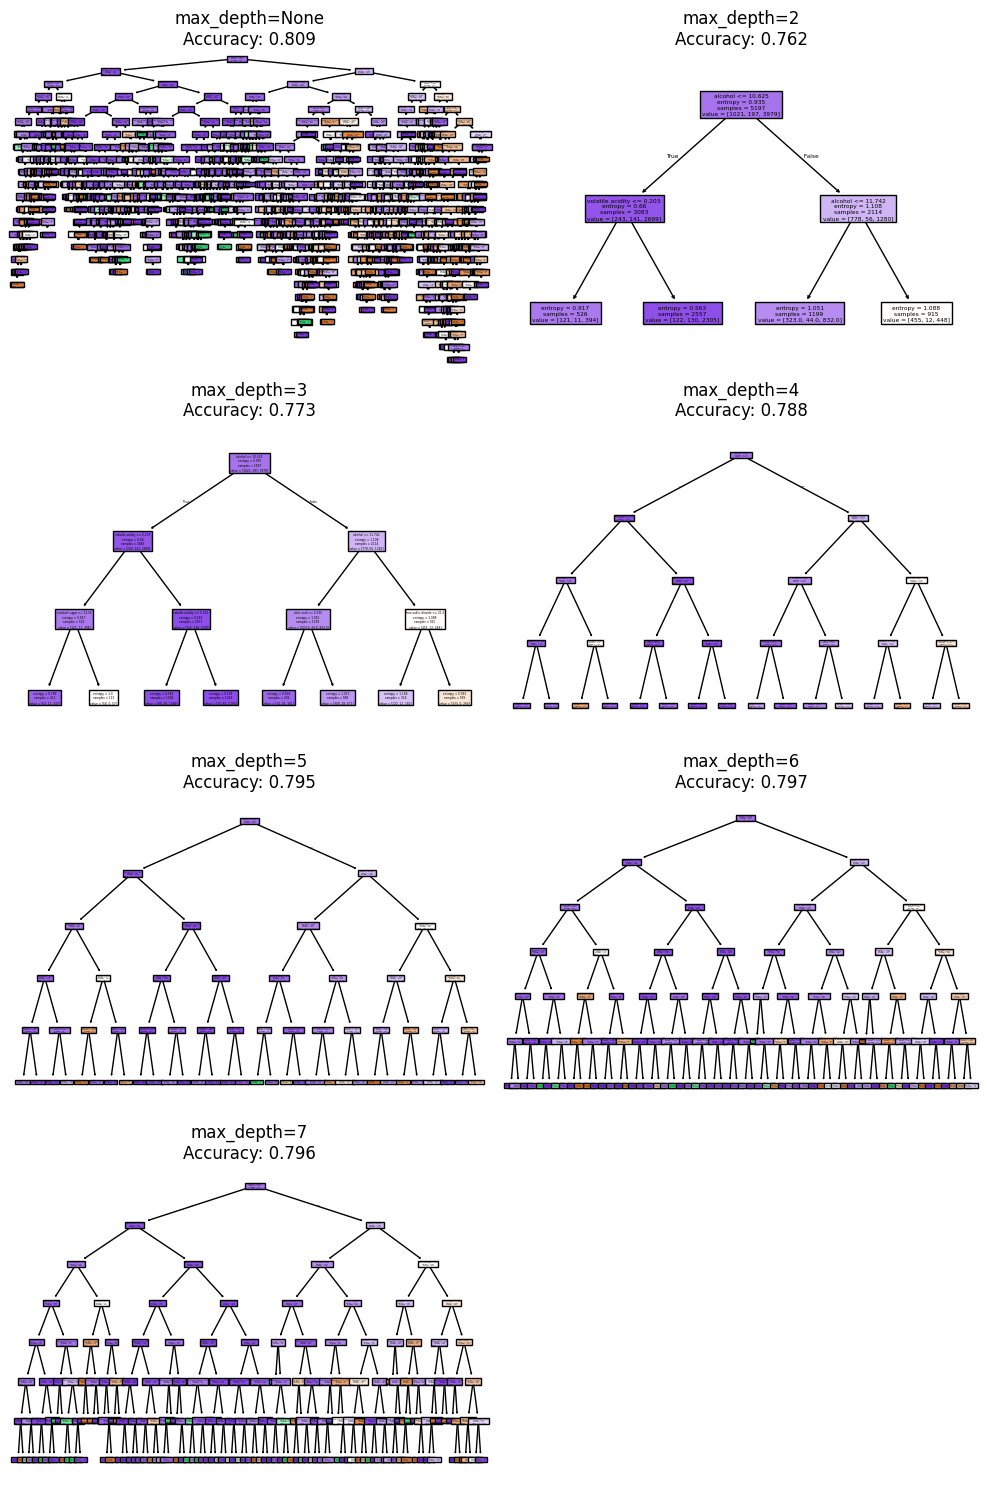

In [7]:
print("\n\nAnalyzing max_depth for 80/20 split...")
X_train = splits['train_80_test_20']['feature_train']
y_train = splits['train_80_test_20']['label_train']
X_test = splits['train_80_test_20']['feature_test']
y_test = splits['train_80_test_20']['label_test']

max_depths = [None, 2, 3, 4, 5, 6, 7]
accuracies = []

plt.figure(figsize=(10, 15))
for i, depth in enumerate(max_depths, 1):
    plt.subplot(4, 2, i)
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    acc = dt.score(X_test, y_test)
    accuracies.append(acc)
    
    plot_tree(dt, feature_names=features.columns, filled=True)
    plt.title(f"max_depth={depth}\nAccuracy: {acc:.3f}")

plt.tight_layout()
plt.show()



max_depth	Accuracy
None    	0.8092
2       	0.7623
3       	0.7731
4       	0.7877
5       	0.7954
6       	0.7969
7       	0.7962


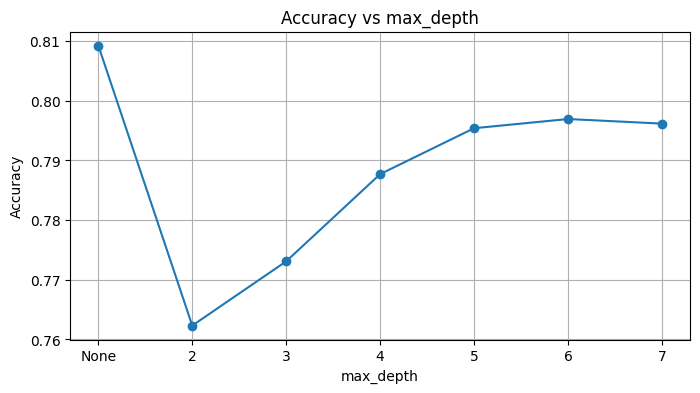

In [8]:
print("\nmax_depth\tAccuracy")
for depth, acc in zip(max_depths, accuracies):
    print(f"{str(depth).ljust(8)}\t{acc:.4f}")

plt.figure(figsize=(8, 4))
plt.plot([str(d) if d else 'None' for d in max_depths], accuracies, 'o-')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs max_depth')
plt.grid(True)
plt.show()